# Training Quantum Boltzmann Machines with the quantum relative entropy

We train the parameters of a Quantum Boltzmann Machine by minimizing the quantum relative entropy between the Gibbs state $\rho_{\theta}$ and the target state $\eta$

$$
S\left(\eta \| \rho_\theta\right)=\operatorname{Tr}[\eta \log \eta]-\operatorname{Tr}\left[\eta \log \rho_\theta\right]
$$

Details about computing this quantity and its gradients with respect to the $\theta$ parameters can be found in [this paper](https://dx.doi.org/10.1088/1751-8121/ab7df6) by Kappen.

## Setup

In [1]:
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
rng = np.random.default_rng(seed=1)

In [3]:
# define number of sites == number of qubits (each site is a 2-level system)
n = 6

## Target state

Here we define the target state we want to _learn_ using the QBM model. A target state can be a quantum encoding of some classical dataset, or it can be a real quantum state.

We focus on the case of real quantum states. A way to generate quantum states is by using quantum circuits, as it is done in the [VQE-generated quantum circuit dataset](http://arxiv.org/abs/2302.09751) paper by Nakayama et al.

In `quimb` we can easily define any state (as long as it fits in memory), starting from a given Hamiltonian. As we have seen in the [00_hamiltonians.ipynb](00_hamiltonians.ipynb) notebook, we can use the transverse-field Ising model Hamiltonian and define a thermal state at some temperature.

Here is the Hamiltonian:

$$
H=J_{z} \sum_{\langle i, j\rangle}  Z_i Z_j  - B_x \sum_j X_j
$$

and the target state is defined as a Gibbs (thermal) state at temperature $T=1/\beta$:

$$
\eta(\beta) = \frac{e^{-\beta H}}{Z} \, ,
$$

with $Z$ the partition function.

In [4]:
# Fix the parameters of the hamiltonian
target_jz = rng.normal()
target_bx = rng.normal()
print(f"Spin interaction used to create target state: {target_jz:.3f}")
print(f"Field value used to create target state: {target_bx:.3f}")

Spin interaction used to create target state: 0.346
Field value used to create target state: 0.822


In [5]:
# create the Hamiltonian of the TFIM
target_tfim = qu.ham_ising(n, target_jz, target_bx)

In [6]:
# fix the temperature of the target state
target_beta = 2.0

Create the thermal state

In [7]:
target_eta = qu.thermal_state(target_tfim, target_beta)

This is the target state we want to learn using a Quantum Boltzmann Machine

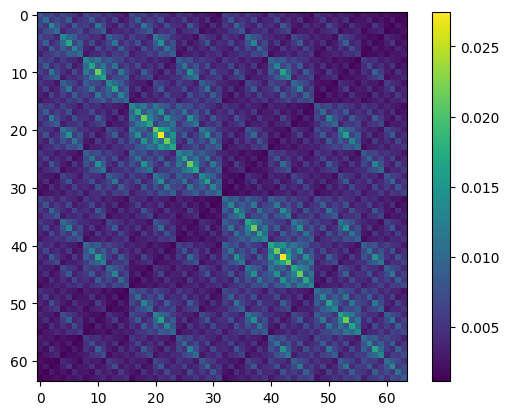

In [8]:
_ = plt.imshow(target_eta, interpolation='nearest')
_ = plt.colorbar()

Instead of visualizing it as a density matrix, one can extract the eigenvalues and compute the Boltzmann probabilities of the eigenstates

In [9]:
target_probs = qu.eigvalsh(target_eta)

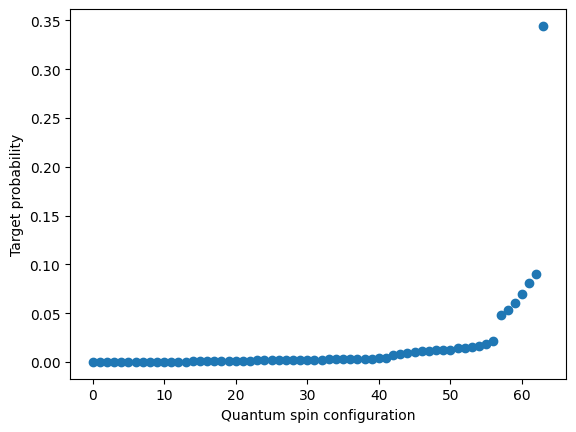

In [14]:
_ = plt.plot(target_probs,'o')
_ = plt.ylabel("Target probability")
_ = plt.xlabel("Quantum spin configuration")

## QBM definition

Let's start by defining the QBM model we want to use. 
For simplicity we will use a model with the same Hamiltonian that we used to generate the target state above. This is a simplification for demonstration purposes. In general, we could use any arbitrary Hamiltonian, with any number of terms, defined in the same Hilbert space as the target state.

Define the QBM Hamiltonian as the transverse-field Ising model

In [15]:
# parameters to learn. Set initial values at random
jz = rng.normal()
bx = rng.normal()
print(f"Spin interaction: {jz:.3f}")
print(f"Field value: {bx:.3f}")

Spin interaction: 0.330
Field value: -1.303


In [16]:
qbm_tfim = qu.ham_ising(n, jz, bx)

In [17]:
qbm_tfim.A

array([[0.41304635, 0.65157862, 0.65157862, ..., 0.        , 0.        ,
        0.        ],
       [0.65157862, 0.24782781, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.65157862, 0.        , 0.08260927, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.08260927, 0.        ,
        0.65157862],
       [0.        , 0.        , 0.        , ..., 0.        , 0.24782781,
        0.65157862],
       [0.        , 0.        , 0.        , ..., 0.65157862, 0.65157862,
        0.41304635]])

Look at the initial Gibbs state defined by this Hamiltonian (we set $\beta=-1$ because we will learn the parameters in the following and $\beta$ is a simple rescaling that does not affect training.)

We follow this definition

$$
\rho_{\theta} = \frac{e^{\mathcal{H}_\theta}}{Z}
$$

In [18]:
rho_qbm = qu.thermal_state(qbm_tfim, -1.0)

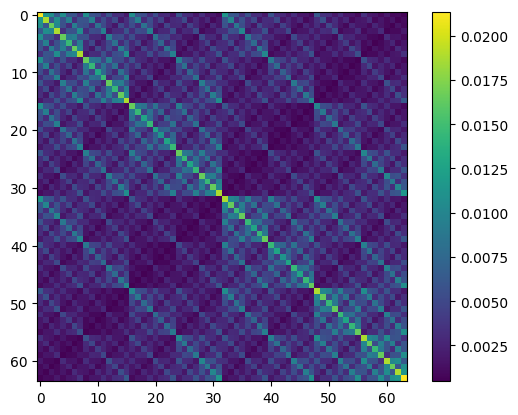

In [19]:
_ = plt.imshow(rho_qbm, interpolation='nearest')
_ = plt.colorbar()

_Roughly speaking_, we would like to make this image look like the target image. We will do so by minimizing the quantum relative entropy, a generalization of the KL divergence from probability distributions to quantum density matrices. We can also have a look at the probability distribution for this initial QBM state

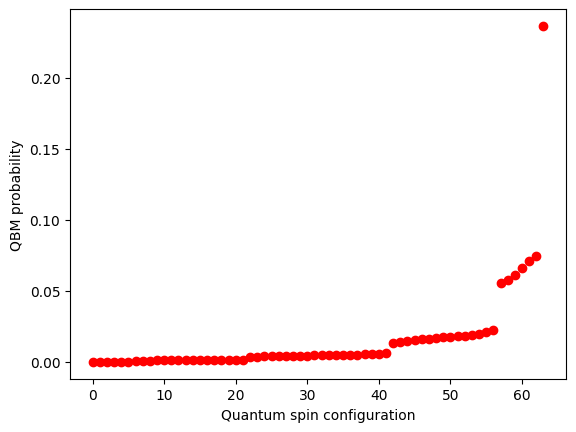

In [22]:
rho_probs = qu.eigvalsh(rho_qbm)
_ = plt.plot(rho_probs,'or')
_ = plt.ylabel("QBM probability")
_ = plt.xlabel("Quantum spin configuration")

## Quantum relative entropy and its gradients

We repeat here the definition of the relative entropy between a target state $\eta$ and a density matrix (our Gibbs state) $\rho_{\theta}$ parameterized by $\theta$:

$$
S\left(\eta \| \rho_\theta\right)=\operatorname{Tr}[\eta \log \eta]-\operatorname{Tr}\left[\eta \log \rho_\theta\right]
$$

**Note** the first terms is the negative von Neumann entropy of $\eta$: $h(\eta) = -\operatorname{Tr}[\eta \log \eta]$

The QBM learning amounts to minimizing $S\left(\eta \| \rho_\theta\right)$, or maximizing the quantum likelihood 

$$
L(\rho) = \operatorname{Tr}\left[\eta \log \rho_\theta\right] = \operatorname{Tr}\left[\eta H_\theta\right] - \log{Z} = \langle H_{\theta} \rangle_{\eta} - \log{Z}
$$

since $h(\eta)$ does not depend on 

$$
\rho_{\theta} = \frac{e^{\mathcal{H}_\theta}}{Z}
$$

In [23]:
# function to compute the quantum relative entropy between the target density and the QBM
def qre(eta, h_qbm):
    """Quantum relative entropy

    Args:
        eta (Any): Target density matrix
        h_qbm (Any): Hamiltonian of the QBM
    """
    # h = qu.entropy(eta) # do not use because it has log2 inside
    evals = qu.eigvalsh(eta)
    h = np.sum(evals * np.log(evals))
    # use log base e all the way
    evals = qu.eigvalsh(h_qbm)
    z = np.sum(np.exp(evals))
    eta_stat = qu.expec(eta, h_qbm)
    return h-eta_stat+qu.log(z)


In [24]:
qre(target_eta, qbm_tfim)

0.1565486887841656

### Gradients

The gradients of the relative entropy w.r.t. the parameters can be written coincisely as

$$
\frac{\partial S\left(\eta \| \rho_\theta\right)}{\partial \theta_i}=\left\langle H_i\right\rangle_{\rho_\theta}-\left\langle H_i\right\rangle_\eta
$$

where $H_i$ are the terms of the QBM Hamiltonian that multiply each of the $\theta_i$ parameters.

In our case we have 2 parameters, and therefore 2 terms $H_i$. They are

$$
H_0 = \sum_{\langle i, j\rangle}  Z_i Z_j
$$

and 

$$
H_1 = - \sum_j X_j
$$

In [25]:
# function to create h0 for the TFIM: this is the two-site term
def h_two_sites(n):
    dims = (2,) * n
    two_site_term = qu.kron(qu.spin_operator('z'), qu.spin_operator('z'))
    def gen_term(i):
        return qu.ikron(two_site_term, dims, [i, i + 1])
    return sum(map(gen_term, range(0,n-1)))


In [26]:
h0 = h_two_sites(n)

In [27]:
h0.A

array([[1.25+0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.75+0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.25+0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       ...,
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.25+0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.75+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 1.25+0.j]])

In [28]:
# function to create h1 for the TFIM: this is the transverse-fiels term (put the minus sign in front)
def h_single_site(n):
    dims = (2,) * n
    single_site_term = qu.spin_operator('x')
    def gen_term(i):
        return qu.ikron(single_site_term, dims, [i])
    return -sum(map(gen_term, range(0,n)))

In [29]:
h1 = h_single_site(n)

In [30]:
h1.A

array([[-0. -0.j, -0.5-0.j, -0.5-0.j, ..., -0. -0.j, -0. -0.j, -0. -0.j],
       [-0.5-0.j, -0. -0.j, -0. -0.j, ..., -0. -0.j, -0. -0.j, -0. -0.j],
       [-0.5-0.j, -0. -0.j, -0. -0.j, ..., -0. -0.j, -0. -0.j, -0. -0.j],
       ...,
       [-0. -0.j, -0. -0.j, -0. -0.j, ..., -0. -0.j, -0. -0.j, -0.5-0.j],
       [-0. -0.j, -0. -0.j, -0. -0.j, ..., -0. -0.j, -0. -0.j, -0.5-0.j],
       [-0. -0.j, -0. -0.j, -0. -0.j, ..., -0.5-0.j, -0.5-0.j, -0. -0.j]])

In [31]:
# test: we should retrive the same TFIM by combining these operators with the parameters
h = jz * h0 + bx * h1
np.allclose(qbm_tfim,h)

True

It is now straighforward to compute the expectation values needed for the gradients

$$
\left\langle H_i\right\rangle_{\rho_\theta}
$$
and
$$
\left\langle H_i\right\rangle_\eta
$$

In [32]:
# first term: two-site operators
h0_rho = qu.expec(rho_qbm, h0)
h0_eta = qu.expec(target_eta, h0)


In [33]:
# second term: single-site operators
h1_rho = qu.expec(rho_qbm, h1)
h1_eta = qu.expec(target_eta, h1)

In [34]:
gradients = [h0_rho-h0_eta, h1_rho-h1_eta]
print(f"Gradients: {gradients}")

Gradients: [0.22700469518370192, 0.2943856335124724]


## Training of the QBM

The last ingredient we need for training the QBM is to use Stochastic Gradient Descent (in this case it is actually exact gradient descent 😄 since the expectation values for the gradients are computed exactly on this small system).

Let us define a learning rate $\gamma$ and a number of epochs (steps):

In [35]:
# learning rate
gamma = 0.2
# number of epochs
epochs = 200

And define a function that computes the gradients and updates the parameters:

In [36]:
def compute_grads(hi, eta, rho):
    """Compute gradients given a list of hamiltonian terms (operators)

    Args:
        hi (List, Tuple): A list of hamiltonian terms
        eta (Any): The target density matrix
        rho (Any): The QBM density matrix

    Returns:
        np.ndarray: The array of the gradients
    """
    grads = []
    for h in hi:
        rho_expect = qu.expec(rho,h)
        eta_expect = qu.expec(eta,h)
        grads.append(rho_expect-eta_expect)
    return np.array(grads)


In [37]:
# test: should match the quantities we got in the previous section!
print(f"Gradients: {compute_grads([h0,h1], target_eta, rho_qbm)}")

Gradients: [0.2270047  0.29438563]


In [38]:
# gradient descent!
def update_params(params, grads, gamma):
    return params - gamma * grads
    

Here is a single epoch:

In [39]:
print(f"Old relative entropy: {qre(target_eta, qbm_tfim)}")

Old relative entropy: 0.1565486887841656


In [40]:
# initialize the QBM with the fixed parameters (2 in our case)
qbm_tfim = jz * h0 + bx * h1
rho = qu.thermal_state(qbm_tfim, -1.0)
grads = compute_grads([h0,h1], target_eta, rho)
new_params = update_params([jz,bx], grads, gamma)
print(f"Old params: {[jz,bx]}")
print(f"New params: {new_params}")

Old params: [0.33043707618338714, -1.303157231604361]
New params: [ 0.28503614 -1.36203436]


In [41]:
# build the new QBM given the updated parameters
qbm_tfim = new_params[0] * h0 + new_params[1] * h1

In [42]:
# the new relative entropy should be lower!
print(f"New relative entropy: {qre(target_eta, qbm_tfim)}")

New relative entropy: 0.13095536147165454


Loop over a fixed number of epochs

In [43]:
# stop when gradient is smaller than epsilon, at the final number of epochs
eps = 1e-6
# keep track of loss and gradients
qre_hist = []
grad_hist = []
for i in range(epochs):
    # create qbm hamiltonians
    qbm_tfim = new_params[0] * h0 + new_params[1] * h1
    qbm_tfim = qbm_tfim.real
    qre_hist.append(qre(target_eta, qbm_tfim))
    # create qbm state
    rho = qu.thermal_state(qbm_tfim, -1.0)
    # grad and update
    grads = compute_grads([h0,h1], target_eta, rho)
    grad_hist.append(np.abs(grads))
    new_params = update_params(new_params, grads, gamma)
    # print diagnostic
    if (i % 10)==0:
        print(f"Quantum relative entropy: {qre_hist[-1]}")
        print(f"Max abs gradient: {np.max(grad_hist[-1])}")
    if np.max(grad_hist[-1]) < eps:
        print(f"Max gradient smaller than precision")
        break
    

Quantum relative entropy: 0.13095536147165543
Max abs gradient: 0.23487392590628065
Quantum relative entropy: 0.04237244626712755
Max abs gradient: 0.13342547013678296
Quantum relative entropy: 0.017540254846557524
Max abs gradient: 0.08602291861592146
Quantum relative entropy: 0.007396936576725466
Max abs gradient: 0.05568525089419457
Quantum relative entropy: 0.0031404475749834404
Max abs gradient: 0.036155692414005264
Quantum relative entropy: 0.001339769279866232
Max abs gradient: 0.02354686510688389
Quantum relative entropy: 0.0005735336280920933
Max abs gradient: 0.015373419860747223
Quantum relative entropy: 0.0002460991111066235
Max abs gradient: 0.010055433490696292
Quantum relative entropy: 0.00010576687060392942
Max abs gradient: 0.0065854134088817184
Quantum relative entropy: 4.550387183588356e-05
Max abs gradient: 0.0043165787823879476
Quantum relative entropy: 1.9590766987320762e-05
Max abs gradient: 0.0028310454190935974
Quantum relative entropy: 8.438313246372786e-06
Ma

The quantum relative entropy decreases and the gradients vanish towards the optimal point.

### Plots of diagnostic quantities

Quantum relative entropy as a function of the epoch number

Text(0, 0.5, 'quantum relative entropy')

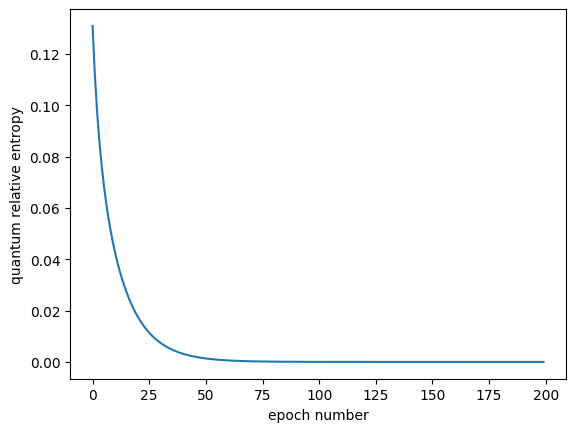

In [44]:
fig, ax = plt.subplots()
ax.plot(qre_hist)
ax.set_xlabel("epoch number")
ax.set_ylabel("quantum relative entropy")

Maximum value of the gradient as a function of the epoch number

Text(0, 0.5, 'Max. of gradients')

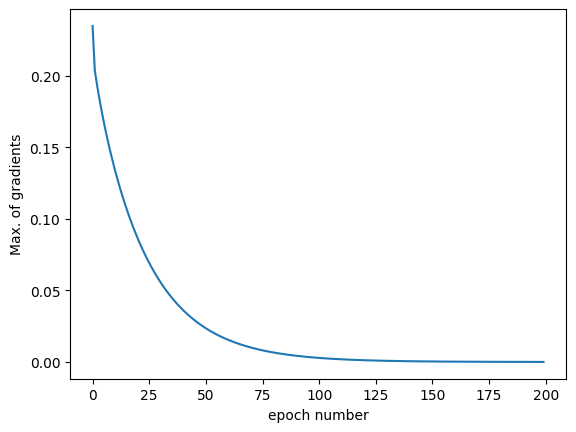

In [45]:
fig, ax = plt.subplots()
ax.plot(np.max(grad_hist,axis=1))
ax.set_xlabel("epoch number")
ax.set_ylabel("Max. of gradients")

### Compare the final parameters with the target parameters. 

**Note** the Hamiltonian is the same but the target state was created with $\beta=2$ and we use a QBM with $\beta=-1$.

In [46]:
print(f"Original target parameters:\n Jz={target_jz} Bx={target_bx}")

Original target parameters:
 Jz=0.345584192064786 Bx=0.8216181435011584


In [47]:
qbm_jz, qbm_bx = -new_params/2
print(f"Trained QBM parameters:\n Jz={qbm_jz} Bx={qbm_bx}")

Trained QBM parameters:
 Jz=0.34548207245451984 Bx=0.821608608671679


In [48]:
# percentage relative difference
print(f"Relative difference:\n Jx={100*(target_jz-qbm_jz)/target_jz:.2f}% Bx={100*(target_bx-qbm_bx)/target_bx:.2f}%")

Relative difference:
 Jx=0.03% Bx=0.00%


Compare the "images" of the target and trained QBM density matrices

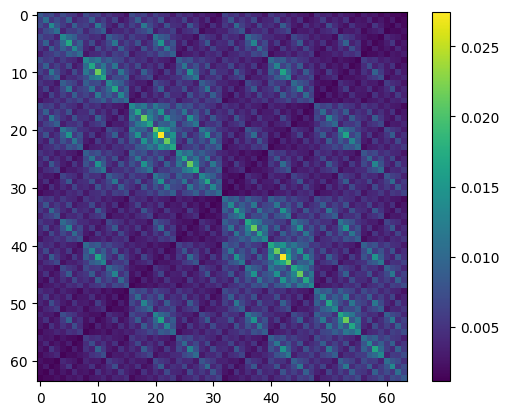

In [49]:
qbm_tfim = new_params[0] * h0 + new_params[1] * h1
qbm_tfim = qbm_tfim.real
rho_qbm = qu.thermal_state(qbm_tfim, -1.0)
_ = plt.imshow(rho_qbm, interpolation='nearest')
_ = plt.colorbar()

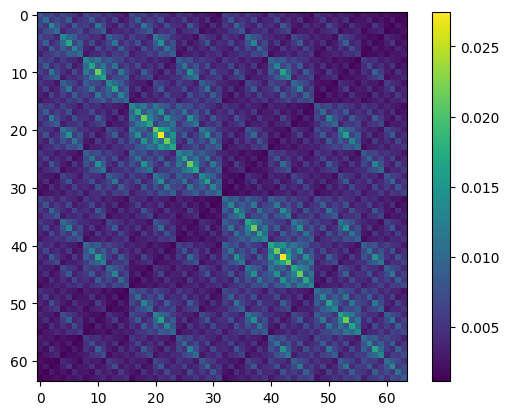

In [41]:
_ = plt.imshow(target_eta, interpolation='nearest')
_ = plt.colorbar()

A way to compare the two density matrices is to compute the fidelity between them. A fidelity close to 1 means the two quantum states are the same

In [50]:
qu.fidelity(target_eta, rho_qbm)

0.9999999991825754

We can also plot the probability distributions:

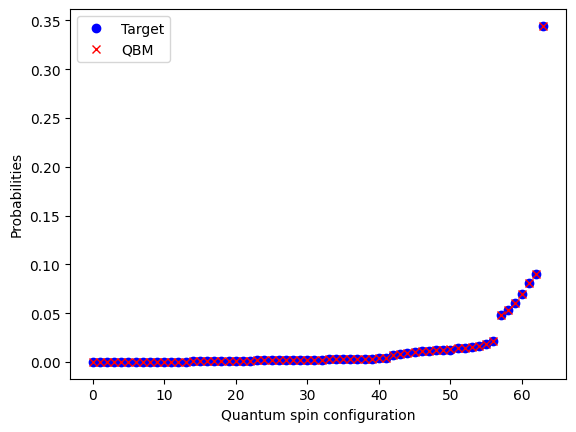

In [52]:
rho_probs = qu.eigvalsh(rho_qbm)
_ = plt.plot(target_probs,'ob')
_ = plt.plot(rho_probs,'xr')
_ = plt.ylabel("Probabilities")
_ = plt.xlabel("Quantum spin configuration")
_ = plt.legend(["Target","QBM"])